In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
os.chdir("/Users/trinhha/Documents/VU AMSTERDAM/STUDY/Thesis/Code/")
from src.evaluation import compute_fidelity
from src.eda import tsne_scatter
import numpy as np
import seaborn as sns
from scipy.stats import jarque_bera
import matplotlib.gridspec as gridspec

plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'  # or other, 'dejavuserif'
plt.rcParams['font.family'] = 'serif'  # or 'DejaVu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 'DejaVu Serif' serif' 'Times'

In [2]:
# Define labels for the metrics to be plotted
metric_labels = {
            "precision": "Precision",
            "recall": "Recall",
            "f1_score": "F1-Score",
            "auc": "AUC",
            "fidelity":  "Fidelity"

        }
metric_used = "AUC"

## 0. Best models

In [3]:
# Get the best baseline model
baseline = pd.read_csv("experiments/perf_summary/baseline_val_results.csv")
baseline_model = baseline.query(f'tuned_by == "{metric_used}"')["version"].astype(str).tolist()
baseline_test_perf = pd.read_csv("results/metrics/baseline.csv")
baseline_test_perf["version"] = baseline_test_perf["version"].astype(str)
baseline_best = baseline_test_perf[baseline_test_perf["version"].isin(baseline_model)]
baseline_best

,accuracy,precision,recall,f1_score,auc,version,timestamp
24,0.780134,0.472909,0.687794,0.560461,0.81813,202505080012,2025-06-10 00:25:54


In [4]:
# Read the test performance of the DP-SGD models
dpsgd = pd.read_csv("experiments/perf_summary/dpsgd_val_results.csv")
dpsgd_models = dpsgd.query(f'tuned_by == "{metric_used}"')["version"].astype(str).tolist()
dpsgd_test_perf = pd.read_csv("results/metrics/dpsgd.csv")
dpsgd_test_perf["version"] = dpsgd_test_perf["version"].astype(str)
dpsgd_best = dpsgd_test_perf[dpsgd_test_perf["version"].isin(dpsgd_models)].sort_values(by="eps", ascending=True)
display(dpsgd_best)

,accuracy,precision,recall,f1_score,auc,version,eps,delta,timestamp
108,0.742254,0.411054,0.611563,0.491651,0.755500,202506071334,1.0,0.00001,2025-06-10 03:54:53
107,0.753775,0.425643,0.595717,0.496520,0.764574,202506070611,3.0,0.00001,2025-06-11 01:29:12
106,0.754473,0.430076,0.629550,0.511038,0.788205,202506070329,5.0,0.00001,2025-06-11 04:26:30


In [5]:
baseline_params = baseline[baseline.columns[6:-1]]
baseline_params["model"] = "Baseline"
dpsgd_params = dpsgd[dpsgd.columns[6:-1]]
dpsgd_params["model"] = "DP-SGD"

summary_params = pd.concat([baseline_params, dpsgd_params], ignore_index=True).drop(columns=["delta"])
summary_params["epsilon"] = summary_params["epsilon"].apply(lambda x: "$\ " if pd.isna(x) else f"{x:.0f}")
summary_params.sort_values(["model", "epsilon"], inplace=True)
summary_params.set_index(["model", "epsilon", "tuned_by"], inplace=True)
summary_params.reset_index(names=["Model", "eps", "Tuning objective"], inplace=True)
summary_params.fillna("-", inplace=True)
summary_params.drop(columns=["q"], inplace=True)
display(summary_params)

# Generate LaTeX table using the requested format
latex_table = r"""\begin{sidewaystable}
    \centering
    \caption{Final hyperparameter configurations by tuning objective}
    \begin{minipage}{\columnwidth} \footnotesize
    \vspace{-2mm}
    Summary of final hyperparameter configurations yielding the highest validation performance based on each tuning objective. Results are reported separately for each model type and privacy budgets ($\varepsilon \in \{1, 3, 5\}$).
    \vspace{2mm}
    \end{minipage}
    \label{tab:final-hyperparams}
    \scriptsize
    \begin{tabular}{llcccccccccc}
    \toprule
    \textbf{Model} & $\varepsilon$ &\textbf{Tuned by} & \textbf{Hidden dimensions} & \textbf{Batch size} & \textbf{Dropout rate} & \textbf{Learning rate} & $\boldsymbol{\lambda}$ & $\boldsymbol{\gamma}$ & \textbf{Threshold} & $\boldsymbol{l_2}$\textbf{-norm clip} & \textbf{Max Epochs} \\
    \midrule
"""
model = "0"
eps = "0"
def to_latex_sci(x, precision=1):
    """Convert a float to LaTeX scientific notation."""
    if isinstance(x, str) or x == "–":
        return x
    return f"${x:.{precision}e}".replace("e", r" \times 10^{") + "}$"

# Add rows from summary_params
for _, row in summary_params.iterrows():
    if model != row["Model"]:
        latex_table += row["Model"]
    else:
        latex_table += ""
    model = row["Model"]
    if eps != row["eps"]:
        latex_table += " & " + row["eps"].replace("$\ ", "")
    else:
        latex_table += " & "
    eps = row["eps"]
    values = row.values[4:]
    values = [f"{val:.3f}".replace(".000", "") if isinstance(val, (int, float)) and (val >= 0.001 or val == 0) else to_latex_sci(val, precision=3) if isinstance(val, (int, float)) else val for val in values]
    latex_table += f" & {row['Tuning objective'].replace('Score', 'score')} & {row['hidden_dims'].replace('(', '[').replace(',)', ']').replace(')', ']')} & " + " & ".join(values) + r" \\" + "\n"
latex_table += r"""    \bottomrule
    \end{tabular}
\end{sidewaystable}"""
print(latex_table)

,Model,eps,Tuning objective,hidden_dims,batch_size,dropout_rate,learning_rate,lam,gamma,threshold,l2norm_pct,max_epochs
0,Baseline,$\,Precision,[64],79.0,0.308206,0.042715,0.031488,0.212212,12.687329,-,-
1,Baseline,$\,Recall,[64],110.0,0.210764,0.050430,0.001106,0.999000,0.034306,-,-
2,Baseline,$\,F1-Score,[64],83.0,0.000000,0.090339,0.002620,0.999000,0.039524,-,-
3,Baseline,$\,AUC,"[64, 32]",83.0,0.000795,0.088987,0.001651,0.999000,0.044370,-,-
4,DP-SGD,1,Precision,[64],114.0,0.207187,0.001527,0.026076,0.304933,10.982668,80.0,204.0
5,DP-SGD,1,Recall,[64],67.0,0.333740,0.001203,0.082912,0.999000,0.312247,85.0,421.0
6,DP-SGD,1,F1-Score,[64],91.0,0.281101,0.000158,0.065214,0.988206,0.948025,87.0,663.0
7,DP-SGD,1,AUC,"[64, 32]",195.0,0.142782,0.001271,0.059730,0.994097,0.618588,79.0,640.0
8,DP-SGD,3,Precision,[64],64.0,0.328941,0.003784,0.068106,0.954600,1.689012,93.0,523.0
9,DP-SGD,3,Recall,"(64,)",200.0,0.023393,0.002862,0.068990,0.998857,0.197818,86.0,636.0


\begin{sidewaystable}
    \centering
    \caption{Final hyperparameter configurations by tuning objective}
    \begin{minipage}{\columnwidth} \footnotesize
    \vspace{-2mm}
    Summary of final hyperparameter configurations yielding the highest validation performance based on each tuning objective. Results are reported separately for each model type and privacy budgets ($\varepsilon \in \{1, 3, 5\}$).
    \vspace{2mm}
    \end{minipage}
    \label{tab:final-hyperparams}
    \scriptsize
    \begin{tabular}{llcccccccccc}
    \toprule
    \textbf{Model} & $\varepsilon$ &\textbf{Tuned by} & \textbf{Hidden dimensions} & \textbf{Batch size} & \textbf{Dropout rate} & \textbf{Learning rate} & $\boldsymbol{\lambda}$ & $\boldsymbol{\gamma}$ & \textbf{Threshold} & $\boldsymbol{l_2}$\textbf{-norm clip} & \textbf{Max Epochs} \\
    \midrule
Baseline &  & Precision & [64] & 79 & 0.308 & 0.043 & 0.031 & 0.212 & 12.687 & - & - \\
 &  & Recall & [64] & 110 & 0.211 & 0.050 & 0.001 & 0.999 & 0.034 & - &

## 1. Performance trade-off

### a. Test set performance (with fixed seed)

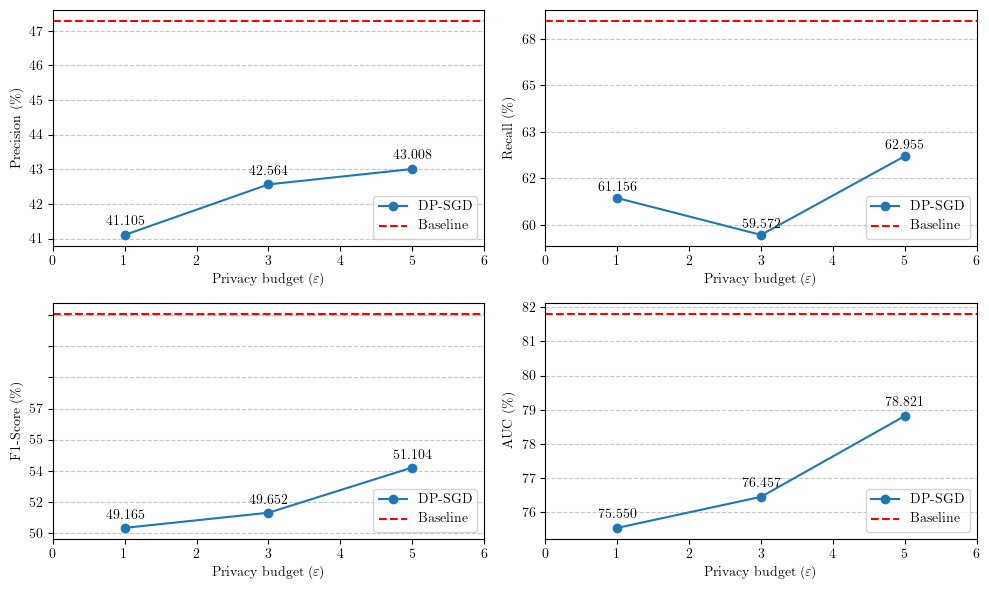

In [6]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, metric in enumerate(metric_labels.keys()):
    if metric != "fidelity":
        ax = axes[i]
        ax.plot(dpsgd_best['eps'], dpsgd_best[metric], marker='o', label='DP-SGD')
        # Add baseline data label
        ax.axhline(y=baseline_best[metric].tolist()[0], color='red', linestyle='--', label='Baseline')
        # Set x axis from 0 to 6
        ax.set_xlim(0, 6)
        # Add data labels
        for j, v in enumerate(dpsgd_best[metric]):
            ax.text(dpsgd_best['eps'].iloc[j], v + 0.002, f"{v * 100:.3f}", ha='center', va='bottom')
        ax.legend(loc='best')
        # Add horizontal grid lines
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        # Set y ticks to percentage
        yticks = ax.get_yticks()
        ax.set_yticklabels([f"{int(v * 100)}" for v in yticks])
        # Set y label
        ax.set_ylabel(metric_labels[metric] + " (\%)")
        # Set x label
        ax.set_xlabel(r'Privacy budget ($\varepsilon$)')

plt.tight_layout()
plt.savefig("results/figures/performance_comparison.png", dpi=300)
plt.show()

### b. Test set performance (with multiple runs)

In [7]:
# Gather the performance metrics and perform normality test
model_list = {"Baseline": f"baseline/{m}" for m in baseline_best["version"].tolist()}
model_list.update({r"$\varepsilon=$" + f"{row['eps']:.0f}": f"dpsgd/{row['version']}" for i, row in dpsgd_best.sort_values("eps", ascending=False).iterrows()})

min_len = min([len(pd.read_csv(f"results/stats_eval/{value}.csv")) for value in model_list.values()])

# Get the seed values
seeds = pd.read_csv("results/stats_eval/seeds.txt", header=None).rename(columns={0:"seed"})

perf_stats = pd.DataFrame()
for key, value in model_list.items():
    print("Model:", key)
    perf = pd.read_csv(f"results/stats_eval/{value}.csv")[:min_len]*100
    perf.insert(0, "Model", key)
    perf["seed"] = seeds

    # Perform normality test
    for i, metric in enumerate(perf.columns.tolist()[1:]):
        if len(perf[perf[metric].notnull()]) > 0:
            stat, p = jarque_bera(perf[metric])
            #print(f"Jarque-Bera test for metric {metric}: stat={stat:.4f}, p={p:.4g}")
            if p < 0.05:
                print("Data does not appear to be normally distributed.")

    perf_stats = pd.concat([perf_stats, perf], ignore_index=True)

Model: Baseline
Model: $\varepsilon=$5
Model: $\varepsilon=$3
Model: $\varepsilon=$1
Data does not appear to be normally distributed.
Data does not appear to be normally distributed.
Data does not appear to be normally distributed.
Data does not appear to be normally distributed.


In [ ]:
from scipy.stats import bootstrap

# Summary table
melt_table = pd.melt(perf_stats.drop(columns=["seed"]), id_vars=['Model'], var_name='MetricType', value_name='Value')
sub_tables = [melt_table[melt_table["Model"]==model].drop(columns=["Model"]).rename(columns={"Value":model}).reset_index(drop=True) for model in melt_table["Model"].unique()]
melted = pd.concat([table if i==0 else table.drop(columns=["MetricType"]) for i, table in enumerate(sub_tables)], axis=1)

# Compute mean
group_mean = melted.groupby("MetricType").mean()
group_mean.columns = [c + "_mean" for c in group_mean.columns]

# Compute CI
def bootstrap_ci(values, alpha=0.05):
    n_boot = 1000
    boot_means = [np.mean(np.random.choice(values, size=len(values), replace=True)) for _ in range(n_boot)]
    boot_means.sort()
    lower_idx = int((alpha / 2) * n_boot)
    upper_idx = int((1 - alpha / 2) * n_boot)

    ci_lower = boot_means[lower_idx]
    ci_upper = boot_means[upper_idx]
    if pd.isna(ci_lower) == False and pd.isna(ci_upper) == False:
        return f"({ci_lower:.3f}, {ci_upper:.3f})"
    else:
        return "--"
group_ci = melted.groupby("MetricType").agg(bootstrap_ci)
group_ci.columns = [c + "_ci" for c in group_ci.columns]

# Combine
combined = pd.concat([group_mean.fillna("--"), group_ci], axis=1)[[item for model in model_list.keys() for item in (f"{model}_mean", f"{model}_ci")]]
combined.reset_index(inplace=True)
combined.columns = pd.MultiIndex.from_tuples([("Metric", "", "")] + [(model, "", stats) if model == "Baseline" else ("DP-SGD", model, stats) for model in model_list.keys() for stats in ("Mean", "95% CI")])

# Re-order
metric_order = list(metric_labels.values())
combined['Metric'] = pd.Categorical(combined['Metric'], categories=metric_order, ordered=True)
combined = combined.sort_values('Metric')
display(combined)

# Make headers
parts = [r' &']  # Presumably for mean/CI of baseline
for key in model_list.keys():
    if key != 'Baseline':
        parts.append(rf'\textbf{{{key}}}')

perf_string = ""
for i, row in combined.iterrows():
    value_str = ' & '.join([f"{row[col]:.3f}" if not isinstance(row[col], str) else row[col] for col in combined.columns if col[2]=="Mean"])
    perf_string += f"""{row[("Metric", "", "")]} & {value_str}\\\\
    & {" & ".join([row[col] for col in combined.columns if col[2]=="95% CI"])} \\\\
    \\addlinespace
    """

script = r"""\begin{table}[tb]
    \centering
    \caption{Summary of validation performance (\%) across baseline and DP-SGD models}
    \begin{minipage}{\columnwidth} \footnotesize
	\vspace{-2mm}
    This table summarizes the test performance of the baseline and DP-SGD models for various privacy levels ($\varepsilon \in \{1, 3, 5\}$), with all models tuned using AUC as the objective. Each cell reports the value of the corresponding evaluation metric in percentage points. The last row, Fidelity, measures the agreement between the predictions of the DP-SGD model and its non-private counterpart, quantifying the behavioral similarity under privacy constraints.
    \vspace{2mm}
    \end{minipage}
    \label{tab:summary_performance}
    \begin{tabular}{l""" + "c" * (len(model_list)) + r"""}
    \toprule
    \textbf{Metric} & \textbf{Baseline} & \multicolumn{""" + str(len(model_list) - 1) + r"""}{c}{\textbf{DP-SGD}} \\
    \cmidrule(lr){3-""" + str(2 + len(model_list) - 1) + r"""}
    """ + ' & '.join(parts).replace("\\varepsilon", "\\boldsymbol{\\varepsilon}") + r""" \\
    \midrule
    """ + perf_string + r"""\bottomrule
    \end{tabular}
\end{table}"""
print(script)

Metric   Baseline                            DP-SGD                    \
                                          $\varepsilon=$5                     
                   Mean            95% CI            Mean            95% CI   
3  Precision   47.70963  (47.388, 47.998)       44.176317  (43.946, 44.395)   
4     Recall  70.226124  (69.800, 70.655)       65.025268  (64.712, 65.372)   
1   F1-Score  56.818434  (56.448, 57.160)       52.610534  (52.343, 52.874)   
0        AUC   83.21334  (82.894, 83.509)       79.947714  (79.664, 80.247)   
2   Fidelity         --                --       85.583312  (85.245, 85.943)   

                                                                       
  $\varepsilon=$3                   $\varepsilon=$1                    
             Mean            95% CI            Mean            95% CI  
3       44.127596  (43.936, 44.306)       41.287751  (41.249, 41.327)  
4       62.799143  (62.539, 63.080)       60.773448  (60.714, 60.828)  
1       51.833157  (51.606, 52.032)       49.170478  (49.125, 49.213)  
0       78.697973  (78.448, 78.943)       75.507889  (75.473, 75.540)  
2       84.258706  (83.944, 84.586)       81.734136  (81.380, 82.053)

\begin{table}[tb]
    \centering
    \caption{Summary of validation performance (\%) across baseline and DP-SGD models}
    \begin{minipage}{\columnwidth} \footnotesize
	\vspace{-2mm}
    This table summarizes the test performance of the baseline and DP-SGD models for various privacy levels ($\varepsilon \in \{1, 3, 5\}$), with all models tuned using AUC as the objective. Each cell reports the value of the corresponding evaluation metric in percentage points. The last row, Fidelity, measures the agreement between the predictions of the DP-SGD model and its non-private counterpart, quantifying the behavioral similarity under privacy constraints.
    \vspace{2mm}
    \end{minipage}
    \label{tab:summary_performance}
    \begin{tabular}{lcccc}
    \toprule
    \textbf{Metric} & \textbf{Baseline} & \multicolumn{3}{c}{\textbf{DP-SGD}} \\
    \cmidrule(lr){3-5}
     & & \textbf{$\boldsymbol{\varepsilon}=$5} & \textbf{$\boldsymbol{\varepsilon}=$3} & \textbf{$\boldsymbol{\varepsilon}=$1} \\
 

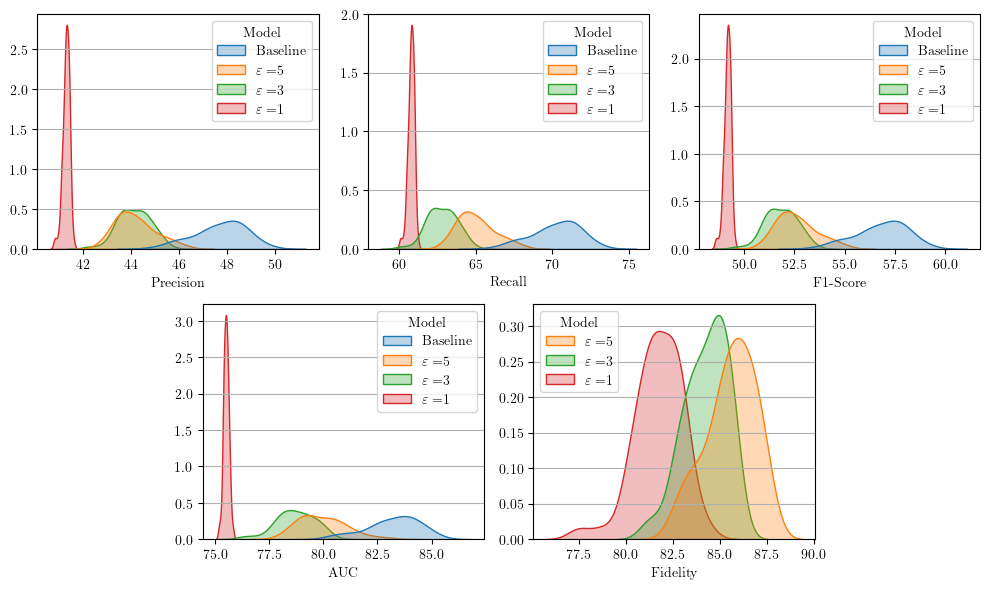

In [ ]:
# KDE plot

# Create subplots
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 6, figure=fig)

colors = sns.color_palette(n_colors=4)
palette = {m: c for m, c in zip(model_list, colors)}

# Create 5 axes in custom positions
axes = [
    fig.add_subplot(gs[0, :2]),  # Top-left
    fig.add_subplot(gs[0, 2:4]),  # Top-right
    fig.add_subplot(gs[0, 4:]),  # Middle-left
    fig.add_subplot(gs[1, 1:3]),  # Middle-right
    fig.add_subplot(gs[1, 3:5])   # Bottom row, spanning both columns (centered)
]

for i, metric in enumerate(perf_stats.drop(columns=["seed"]).columns.tolist()[1:]):
    ax = axes[i]
    sub_perf_stats = perf_stats[perf_stats[metric].notnull()]
    sns.kdeplot(data=sub_perf_stats, x=metric, hue="Model", ax=axes[i],
            fill=True, common_norm=False, alpha=0.3, linewidth=1, palette=palette)
    axes[i].set_ylabel("")
    axes[i].set_xlabel(metric)
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()

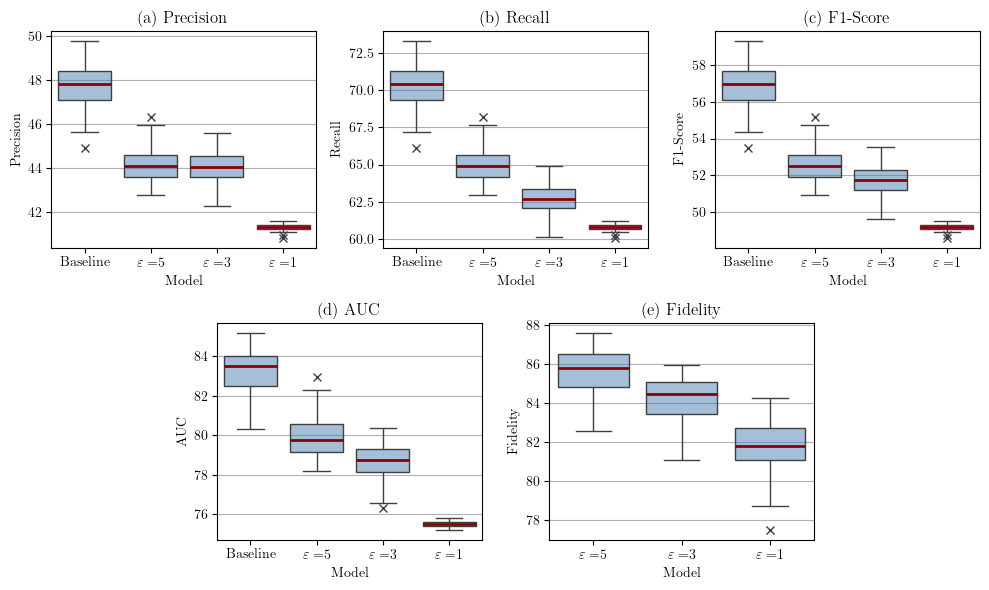

In [ ]:
# Boxplot

# Create subplots
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 6, figure=fig)

# Create 5 axes in custom positions
axes = [
    fig.add_subplot(gs[0, :2]),  # Top-left
    fig.add_subplot(gs[0, 2:4]),  # Top-right
    fig.add_subplot(gs[0, 4:]),  # Middle-left
    fig.add_subplot(gs[1, 1:3]),  # Middle-right
    fig.add_subplot(gs[1, 3:5])   # Bottom row, spanning both columns (centered)
]

for i, metric in enumerate(perf_stats.drop(columns=["seed"]).columns.tolist()[1:]):
    ax = axes[i]
    sub_perf_stats = perf_stats[perf_stats[metric].notnull()]
    sns.boxplot(data=sub_perf_stats, x="Model", y=metric, ax=axes[i],
        flierprops={"marker": "x"},
        boxprops={"facecolor": (.3, .5, .7, .5)},
        medianprops={"color": "darkred", "linewidth": 2},
        notch=False, showcaps=True)
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel(metric)
    axes[i].grid(axis='y')
    axes[i].set_title(f"({chr(97 + i)}) {metric}")

plt.tight_layout()
plt.savefig("results/figures/performance_comparison_distr.png")
plt.show()

In [ ]:
# Paired t-test

from itertools import permutations
from scipy.stats import ttest_rel

for metric in metric_labels.values():
    print(metric)
    if metric != "Fidelity":
        p_models = list(model_list.keys()).copy()
    else:
        p_models = [m for m in model_list.keys() if m!='Baseline']
    table = pd.DataFrame(None, index=p_models, columns=p_models)
    for m1, m2 in permutations(p_models, 2):
        perf_1 = perf_stats[perf_stats["Model"]==m1]
        perf_2 = perf_stats[perf_stats["Model"]==m2]
        min_len = min([len(perf_1), len(perf_2)])
        stat, p = ttest_rel(perf_1[metric][:min_len], perf_2[metric][:min_len])
        # Convert to one-sided
        if stat > 0:
            p_one_sided = p / 2
            table.loc[m1, m2] = f"{stat:.3f} (p = {p_one_sided:.3f})"
        else:
            table.loc[m1, m2] = "--"
    table.fillna("--", inplace=True)
    for col in table.columns:
        if len(table[table[col]!="--"])==0:
            table.drop(columns=[col], inplace=True)
    display(table)

Precision


,$\varepsilon=$5,$\varepsilon=$3,$\varepsilon=$1
Baseline,18.705 (p = 0.000),18.389 (p = 0.000),42.269 (p = 0.000)
$\varepsilon=$5,--,0.291 (p = 0.386),23.844 (p = 0.000)
$\varepsilon=$3,--,--,28.070 (p = 0.000)
$\varepsilon=$1,--,--,--


Recall


,$\varepsilon=$5,$\varepsilon=$3,$\varepsilon=$1
Baseline,18.705 (p = 0.000),26.170 (p = 0.000),42.269 (p = 0.000)
$\varepsilon=$5,--,9.160 (p = 0.000),23.844 (p = 0.000)
$\varepsilon=$3,--,--,14.035 (p = 0.000)
$\varepsilon=$1,--,--,--


F1-Score


,$\varepsilon=$5,$\varepsilon=$3,$\varepsilon=$1
Baseline,18.705 (p = 0.000),21.581 (p = 0.000),42.269 (p = 0.000)
$\varepsilon=$5,--,3.921 (p = 0.000),23.844 (p = 0.000)
$\varepsilon=$3,--,--,22.384 (p = 0.000)
$\varepsilon=$1,--,--,--


AUC


,$\varepsilon=$5,$\varepsilon=$3,$\varepsilon=$1
Baseline,15.466 (p = 0.000),20.318 (p = 0.000),44.626 (p = 0.000)
$\varepsilon=$5,--,6.099 (p = 0.000),28.497 (p = 0.000)
$\varepsilon=$3,--,--,25.126 (p = 0.000)
$\varepsilon=$1,--,--,--


Fidelity


,$\varepsilon=$3,$\varepsilon=$1
$\varepsilon=$5,8.389 (p = 0.000),27.231 (p = 0.000)
$\varepsilon=$3,--,18.016 (p = 0.000)
$\varepsilon=$1,--,--


### c. Convergence

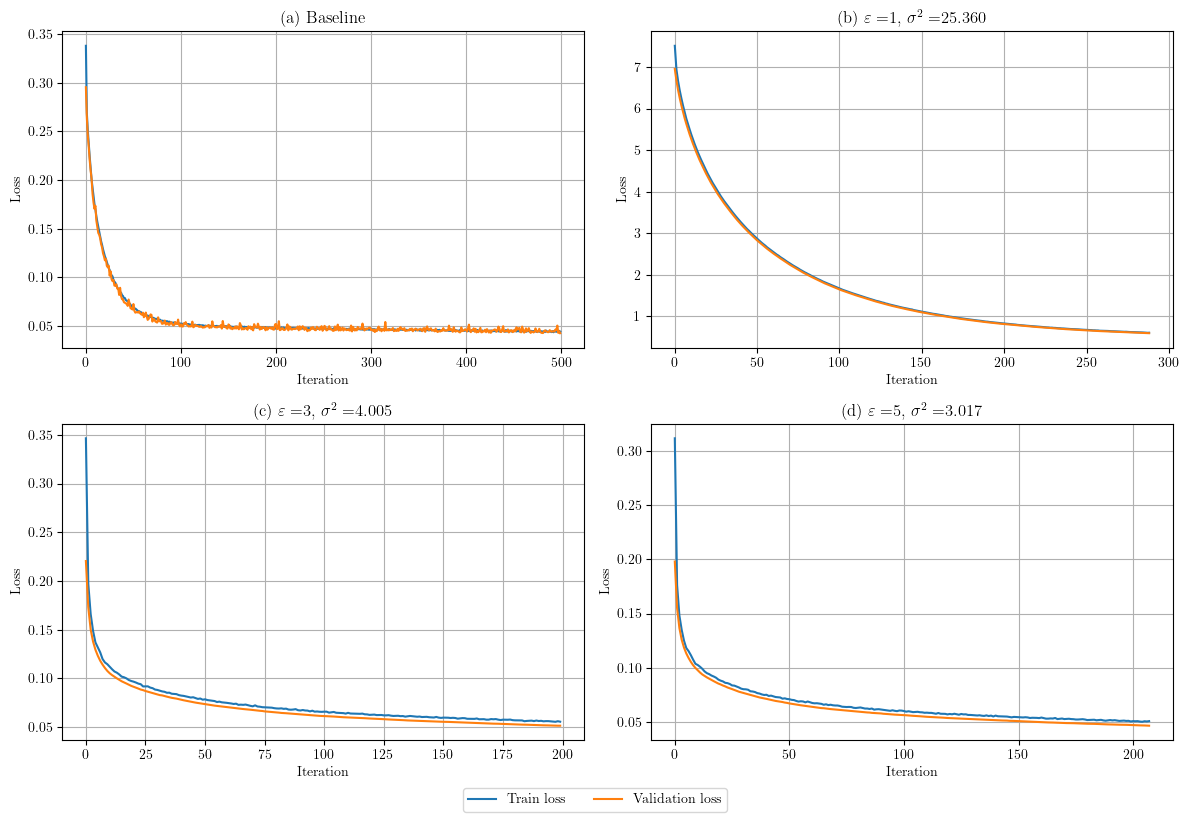

In [ ]:
# Layout: 2×2 grid with a subplot for each model
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

def plot_loss(ax, results_df, epsilon=None, noise=None):
    # Plot loss on the left y-axis
    train = ax.plot(results_df.index, results_df["train_loss"], label='Train loss')
    val = ax.plot(results_df.index, results_df["val_loss"], label='Validation loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.tick_params(axis='y')
    if epsilon is not None:
        ax.set_title(f"({chr(97 + i + 1)}) " + r"$\varepsilon =$" + f"{epsilon:.0f}" + r", $\sigma^2 =$" + f"{noise:.3f}")
    else:
        ax.set_title("(a) Baseline")
    ax.grid(True)

    lns = train + val

    return ax, lns

ax = axes[0]
# Plot baseline performance
baseline_version = baseline_best["version"].astype(str).tolist()[0]
results_df = pd.read_csv(f"experiments/tracking/{baseline_version}_baseline.csv")
ax, lns = plot_loss(ax, results_df)

# Iterate through the rows of dpsgd_best DataFrame
for i, row in dpsgd_best.reset_index(drop=True).iterrows():
    # Flatten the axes for easy indexing
    ax = axes[i + 1]
    # Extract the version and epsilon from the row
    version = row["version"]
    epsilon = row["eps"]

    # Read result file
    folder = "experiments/tracking"

    # Read the existing files with the same version prefix
    pattern = os.path.join(folder, f"{version}_noise*.csv")
    for file in glob.glob(pattern):
        results_df = pd.read_csv(file)
        noise = float(file.split("noise")[-1].split(".csv")[0])

    # Plot loss
    ax, lns = plot_loss(ax, results_df, epsilon, noise)

# added these three lines
labs = [l.get_label() for l in lns]
fig.legend(lns, labs, loc='lower center', bbox_to_anchor=(0.5, -0.03),
           ncol=3)

plt.tight_layout()
plt.savefig("results/figures/convergence_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

### d. Summary table creation

In [ ]:
# Compute fidelity
# Read the baseline predictions
baseline_predictions = pd.read_feather(f"experiments/predictions/baseline/{baseline_version}_pred.feather")
# Define a function to compute fidelity for each DP-SGD version
def get_fidelity(model_type, dpsgd_version):
    dpsgd_predictions = pd.read_feather(f"experiments/predictions/{model_type}/{dpsgd_version}_pred.feather")
    fidelity = compute_fidelity(baseline_predictions, dpsgd_predictions)
    return fidelity
# Get the fidelity of the DP-SGD models
dpsgd_best["fidelity"] = dpsgd_best["version"].apply(lambda x: get_fidelity("dpsgd", x))
display(dpsgd_best)

,accuracy,precision,recall,f1_score,auc,version,eps,delta,timestamp,fidelity
108,0.742254,0.411054,0.611563,0.491651,0.755500,202506071334,1.0,0.00001,2025-06-10 03:54:53,0.710134
107,0.753775,0.425643,0.595717,0.496520,0.764574,202506070611,3.0,0.00001,2025-06-11 01:29:12,0.727241
106,0.754473,0.430076,0.629550,0.511038,0.788205,202506070329,5.0,0.00001,2025-06-11 04:26:30,0.724448


### e. t-SNE plot

In [ ]:
def plot_tsne(model_type, version):   
    # Read the predictions
    predictions = pd.read_feather(f"experiments/predictions/{model_type}/{version}_pred.feather")
    # Read the features
    features = pd.read_feather(f"experiments/predictions/{model_type}/{version}_recons.feather")
    # Create the scatter plot
    tsne = tsne_scatter(features.values, predictions.anomaly.values, dimensions=2)
    tsne.savefig(f"results/figures/{model_type}_{version}_tsne.png", dpi=300)
    tsne.show()

"""for value in model_list.values():
    model_type = value.split("/")[0]
    version = value.split("/")[-1]
    plot_tsne(model_type, version)"""

'for value in model_list.values():\n    model_type = value.split("/")[0]\n    version = value.split("/")[-1]\n    plot_tsne(model_type, version)'